# Confusion matrix 만들기

In [1]:
import json
import pandas as pd
from pandas import json_normalize

## ground truth.json 불러오기
1. 파일을 읽어서 dataframe에 넣기
2. gameTime, label만 추출
3. gameTime에서 분:초를 제외한 데이터 삭제

In [2]:
with open("C:\\Users\\user\\Desktop\\Jupyter\\TASK1_Confusion_matrix\\input\\groun_truth.json", "r", encoding="utf8") as f:
    contents = f.read() # string 타입
    json_data = json.loads(contents)
df_json_data_groun_truth = json_normalize(json_data['annotations']) # json파일 -> dataframe에 넣기
df_json_data_groun_truth = df_json_data_groun_truth.loc[:, ['gameTime', 'label']] # 내가 원하는 데이터만 추출
df_json_data_groun_truth['gameTime'] = df_json_data_groun_truth.gameTime.str.split(' - ').str[1]  # 1 - , 2 - 와 같은 데이터 삭제

df_json_data_groun_truth # 출력

,gameTime,label
0,00:00,Other
1,00:14,Shots on target
2,00:15,Goal
3,00:26,Goal
4,02:49,Direct free-kick
...,...,...
338,116:36,Goal
339,116:42,Corner
340,116:46,Goal
341,116:50,Corner


## prediction.json 불러오기
1. 파일을 읽어서 dataframe에 넣기
2. gameTime, label만 추출
3. gameTime에서 분:초 가 아닌 데이터 삭제
4. 특정 threshold를 기준으로 데이터 줄이기
5. gameTime에서 Min, Sec을 추출하여 정렬하기

In [3]:
confidence_threshold = 0.5


with open("C:\\Users\\user\\Desktop\\Jupyter\\TASK1_Confusion_matrix\\input\\prediction.json", "r", encoding="utf8") as f:
    contents = f.read() # string 타입
    json_data = json.loads(contents)
df = json_normalize(json_data['predictions'])  # json파일 -> dataframe에 넣기
df = df.loc[:, ['gameTime', 'label', 'confidence', 'half']]   # 내가 원하는 데이터만 추출
df['gameTime'] = df.gameTime.str.split(' - ').str[1]  # 1 - , 2 - 와 같은 데이터 삭제
df['confidence'] = df['confidence'].astype(float)     # 내가 원하는 퍼센트 이상만 받기 위해 float형으로 변환
index_drop = df[df['confidence'] < confidence_threshold].index         # 특정 값 이하 삭제의 index 모으기
df.drop(index_drop, inplace=True)                       # 해당 index 삭제

df['MIN'] = df.gameTime.str.split(':').str[0]  # gameTime에서 분 추출
df['MIN'] = pd.to_numeric(df['MIN'])
df['SEC'] = df.gameTime.str.split(':').str[1]  # gameTime에서 초 추출
df['SEC'] = pd.to_numeric(df['SEC'])

# predict "1 - "의 분, 초가 58분 31초에서 끊겨서 "2 - "에는 해당 숫자만큼 더하여 진행
for i in df.index :
    if df['half'][i] == "2" :
        df['MIN'][i] += 58
        df['SEC'][i] += 31


df_json_data_prediction = df.sort_values(by = ['MIN', 'SEC']) # gameTime을 기준으로 정렬
# df_json_data_prediction # 출력

C:\Users\user\AppData\Local\Temp\ipykernel_17600\1304093163.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MIN'][i] += 58
C:\Users\user\AppData\Local\Temp\ipykernel_17600\1304093163.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SEC'][i] += 31


### 실제 데이터를 사용하기 전에 빠른 확인을 위한 prediction.json 데이터 줄이기
groun_truth.json은 input -> small_input으로 가져올 때 수정으로 삭제

In [4]:
# MIN 행 중 20분 이상인게 있는지 확인하고 drop하며 input 크기 줄이기
# index_drop = df_json_data_prediction[df_json_data_prediction['MIN'] > 19].index         # 특정 값 이하 삭제의 index 모으기
# df_json_data_prediction.drop(index_drop, inplace=True)                                          # 해당 index 삭제

df_json_data_prediction = df_json_data_prediction.reset_index(drop=True) # 인덱스 재설정
df_json_data_prediction # 출력

,gameTime,label,confidence,half,MIN,SEC
0,0:14,Corner,0.896660,1,0,14
1,0:16,Ball out of play,0.550042,1,0,16
2,0:31,Kick-off,0.757758,1,0,31
3,1:20,Substitution,0.551063,1,1,20
4,2:14,Substitution,0.514771,1,2,14
...,...,...,...,...,...,...
416,58:4,Corner,0.937923,2,116,35
417,58:5,Goal,0.880127,2,116,36
418,58:21,Goal,0.537783,2,116,52
419,58:32,Kick-off,0.940929,2,116,63


시간 비교를 위해 df_json_data_groun_truth, df_json_data_prediction의 Game time을 지우고 MIN * 60 + Second로 Time label 추가.

In [5]:
df_json_data_groun_truth['MIN'] = df_json_data_groun_truth.gameTime.str.split(':').str[0]  # gameTime에서 분 추출
df_json_data_groun_truth['MIN'] = pd.to_numeric(df_json_data_groun_truth['MIN'])
df_json_data_groun_truth['SEC'] = df_json_data_groun_truth.gameTime.str.split(':').str[1]  # gameTime에서 초 추출
df_json_data_groun_truth['SEC'] = pd.to_numeric(df_json_data_groun_truth['SEC'])

In [6]:
df_json_data_groun_truth['Time'] = df_json_data_groun_truth['MIN']*60 + df_json_data_groun_truth['SEC']
df_json_data_groun_truth.drop(['gameTime', 'MIN', 'SEC'], axis=1, inplace=True)

df_json_data_prediction['Time'] = df_json_data_prediction['MIN']*60 + df_json_data_prediction['SEC']
df_json_data_prediction.drop(['gameTime', 'MIN', 'SEC'], axis=1, inplace=True)

df_json_data_prediction

,label,confidence,half,Time
0,Corner,0.896660,1,14
1,Ball out of play,0.550042,1,16
2,Kick-off,0.757758,1,31
3,Substitution,0.551063,1,80
4,Substitution,0.514771,1,134
...,...,...,...,...
416,Corner,0.937923,2,6995
417,Goal,0.880127,2,6996
418,Goal,0.537783,2,7012
419,Kick-off,0.940929,2,7023


## confusion matrix
참고자료

1. https://panython.tistory.com/20

2. http://datascienceschool.net/03%20machine%20learning/09.04%20%EB%B6%84%EB%A5%98%20%EC%84%B1%EB%8A%A5%ED%8F%89%EA%B0%80.html

In [7]:
# confusion matrix 사용을 위한 라이브러리
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib

import matplotlib.pyplot as plt
import numpy as np

#### Exercise

http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/

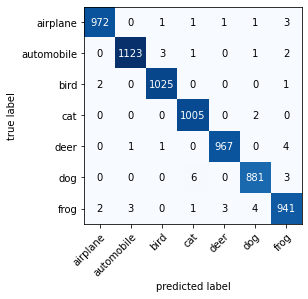

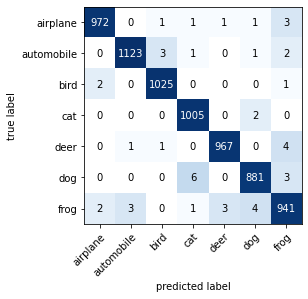

In [8]:
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog'}

cmat = np.array([[972, 0, 1, 1, 1, 1, 3],
                 [0, 1123, 3, 1, 0, 1, 2],
                 [2, 0, 1025, 0, 0, 0, 1],
                 [0, 0, 0, 1005, 0, 2, 0],
                 [0, 1, 1, 0, 967, 0, 4],
                 [0, 0, 0, 6, 0, 881, 3],
                 [2, 3, 0, 1, 3, 4, 941]])

fig, ax = plot_confusion_matrix(
    conf_mat=cmat,
    class_names=class_dict.values(),
)
fig, ax = plot_confusion_matrix(
    conf_mat=cmat,
    class_names=class_dict.values(),
    norm_colormap=matplotlib.colors.LogNorm()  
)

#### Counting
    인풋 :1. df_json_data_groun_truth -> game_time, label이 있는 dataframe
          2. df_json_data_prediction  -> game_time, label이 있는 dataframe
          나머지 데이터는 여기부터 필요 X
          
    아웃풋 : cmat에 숫자를 추가한 것

In [9]:
class_dict = {0 : 'Ball out of play',
              1 : 'Throw-in',
              2 : 'Foul',
              3 : 'Indirect free-kick',
              4 : 'Clearance',
              5 : 'Shots on target',
              6 : 'Shots off target',
              7 : 'Corner',
              8 : 'Substitution',
              9 : 'Kick-off',
              10 : 'Yellow card',
              11 : 'Offside',
              12 : 'Direct free-kick',
              13 : 'Goal',
              14 : 'Penalty',
              15 : 'Red card',
              16 : 'Start of game',
              17 : 'End of game',
              18 : 'Start of replay',
              19 : 'End of replay',
              20 : 'Yellow card -> red card',
              21 : 'Other',
              22 : 'NONE'}

In [10]:
# class_dict.reverse()
class_dict = dict(map(reversed,class_dict.items()))
print(type(class_dict))

<class 'dict'>


In [11]:
class_dict
print(len(class_dict))

23


In [12]:
cmat = np.array([0]*len(class_dict)*len(class_dict)).reshape((len(class_dict), len(class_dict)))
# cmat = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

1. GT를 for문으로 지나면서 가장 가까운 predict을 찾기
2. 둘을 삭제하면서 cmat에 +1
    - 만약 초를 지났을 때 까지 없다면 pass
3. 남은 predict(or GT)를 NONE과 매치하면서 +1

In [13]:
 df_json_data_prediction.reset_index(drop=True, inplace = True) # 인덱스 재설정

In [14]:
df_json_data_prediction

,label,confidence,half,Time
0,Corner,0.896660,1,14
1,Ball out of play,0.550042,1,16
2,Kick-off,0.757758,1,31
3,Substitution,0.551063,1,80
4,Substitution,0.514771,1,134
...,...,...,...,...
416,Corner,0.937923,2,6995
417,Goal,0.880127,2,6996
418,Goal,0.537783,2,7012
419,Kick-off,0.940929,2,7023


In [15]:
time_interval_threshole = 5

for i in df_json_data_groun_truth.index:
    min_time_diff = df_json_data_groun_truth["Time"][i] - df_json_data_prediction["Time"][0]
    index = 0
    SUM = True
    for j in df_json_data_prediction.index:
        temp = df_json_data_groun_truth["Time"][i] - df_json_data_prediction["Time"][j]
        if temp > time_interval_threshole :
            continue
            
        elif temp < -1 * time_interval_threshole :
            break
            
        else :
            if df_json_data_groun_truth["label"][i]== df_json_data_prediction["label"][j] :
                SUM = True
                index = j
                break
            else :
                if abs(min_time_diff) >= abs(temp):
                    SUM = True
                    index = j
            
    if SUM :
        x = class_dict.get(df_json_data_groun_truth["label"][i])
        y = class_dict.get(df_json_data_prediction["label"][index])

        cmat[x,y] += 1
        df_json_data_prediction.drop(index, inplace=True)
        df_json_data_prediction = df_json_data_prediction.reset_index(drop=True) # 인덱스 재설정

    else :
        x = class_dict.get(df_json_data_groun_truth["label"][i])
        cmat[x, 22] += 1


In [16]:
print(cmat)

[[35  2  0  0  5  4  0  0  4 21  0  0  1  5  0  0  0  0  0  0  0  0  0]
 [ 9  7  0  0  3  1  0  2  2 18  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 8  0  0  0  1  0  0  1  1  8  1  0  0  2  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  2  1  0  3  1 11  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 3  0  0  0  2  1  0  0  1  8  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  9  0  1  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  1  6  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  1  1  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  1 13 18  0  0  0  4  0  0  0  0  0  0  0

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


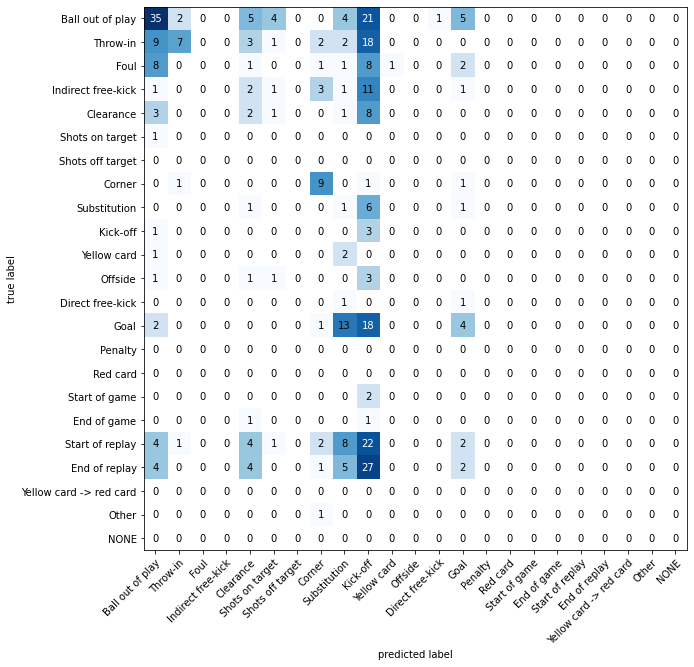

In [17]:
fig, ax = plot_confusion_matrix(
    conf_mat=cmat, figsize = (10, 10),
    class_names=class_dict.keys(),
    norm_colormap=matplotlib.colors.LogNorm()  
)

## Precision, recall 구하기

### 간단환 코드로 구현하고, 대입

## label 별 FP, FN , ... 구하기

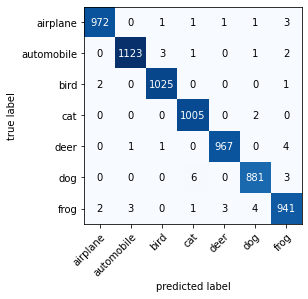

In [18]:
temp_class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog'}

temp_cmat = np.array([[972, 0, 1, 1, 1, 1, 3],
                 [0, 1123, 3, 1, 0, 1, 2],
                 [2, 0, 1025, 0, 0, 0, 1],
                 [0, 0, 0, 1005, 0, 2, 0],
                 [0, 1, 1, 0, 967, 0, 4],
                 [0, 0, 0, 6, 0, 881, 3],
                 [2, 3, 0, 1, 3, 4, 941]])

fig, ax = plot_confusion_matrix(
    conf_mat=temp_cmat,
    class_names=temp_class_dict.values(),
)

In [19]:
sum_total = np.sum(temp_cmat)
print(sum_total)

6961


In [20]:
columns = ["TP", "FN", "FP", "TN"]
lable_score = pd.DataFrame(columns=columns)

In [21]:
columns

['TP', 'FN', 'FP', 'TN']

In [22]:
sum_column = np.array(temp_cmat.sum(axis=0))


for idx in range(0, len(temp_class_dict)):
    TP = 0
    FN = 0
    
    for idx_x, value_x in enumerate(temp_cmat[idx]):
        if idx_x == idx :
            TP = value_x
        else:
            FN += value_x

    FP = sum_column[idx] - TP
    TN = sum_total - TP - FN - FP
    lable_score.loc[idx] = [TP, FN, FP, TN]
    
# dataFrame 완성

In [23]:
lable_score

,TP,FN,FP,TN
0,972,7,4,5978
1,1123,7,4,5827
2,1025,3,5,5928
3,1005,2,9,5945
4,967,6,4,5984
5,881,9,8,6063
6,941,13,13,5994


## precision, recall 계산

In [24]:
lable_score["Precision"] = lable_score["TP"] / (lable_score["FP"] + lable_score["TP"])
lable_score["Recall"] = lable_score["TP"] / (lable_score["FN"] + lable_score["TP"])

In [25]:
lable_score

,TP,FN,FP,TN,Precision,Recall
0,972,7,4,5978,0.995902,0.992850
1,1123,7,4,5827,0.996451,0.993805
2,1025,3,5,5928,0.995146,0.997082
3,1005,2,9,5945,0.991124,0.998014
4,967,6,4,5984,0.995881,0.993834
5,881,9,8,6063,0.991001,0.989888
6,941,13,13,5994,0.986373,0.986373


## label 별 시각화
1. confusion matrix 시각화

In [26]:
# for i in lable_score.index: